## Modeling yields based on Country and Year. 

This notebook creates models which predicts yields based under different temperature and climate conditions, both historic and projected. 

Projected climate data was gathered from NASA and can be found here: https://www.nccs.nasa.gov/services/climate-data-services

In [1]:
#import 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for modeling 
from sklearn.linear_model import LinearRegression
from sklearn import metrics, linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from numpy import NaN
from sklearn.linear_model import LassoCV, RidgeCV,Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, median_absolute_error


import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.stats import pearsonr
%matplotlib inline

In [2]:
df = pd.read_csv('data/thisisdf.csv')


#feature engingeering
df['pop-temp'] = (df['Population'] / df['AverageTemperature']) * df['AverageTemperature']

df['pop-precip'] = (df['Population'] / df['Average monthly precipitation']) * df['Average monthly precipitation']

In [146]:
#Import cleaned, feature engineered data 

#no mitigation data 
no_mitigation_merged = pd.read_csv('data/Data2/no_mit_merged.csv')

#mitigation data 
mitigation_merged = pd.read_csv('data/Data2/mit_merged.csv')


# Using simple lasso model for insight into important model coefficients 

In [26]:
features = [cols for cols in df._get_numeric_data().columns if cols != 'total_yield']

#defining features
X = df[['Year','AverageTemperature', 'temp_anomalies','temp_pct_change', 'Average monthly precipitation', 'precip_change', 
        'pop-temp', 'pop-precip','AverageTemperatureUncertainty', 'Surface temperature anomaly', 'pop-temp', 'pop-precip','precip_temp']]
y = df['total_yield']

In [27]:
#train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [28]:
l_alphas = np.logspace(-3,0,100)

# Cross-validate over our list of Lasso alphas.
lasso_model = LassoCV(alphas = l_alphas, cv = 5)

# Fit model using best ridge alpha!

lasso_model = lasso_model.fit(X_train, y_train)

In [30]:
coefs = pd.Series(lasso_model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs!= 0)) + " features and eliminated the other " +  \
str(sum(coefs == 0)) + " features")

Lasso picked 12 features and eliminated the other 1 features


Text(0.5, 1.0, 'Strong Coefficients in the Lasso Model')

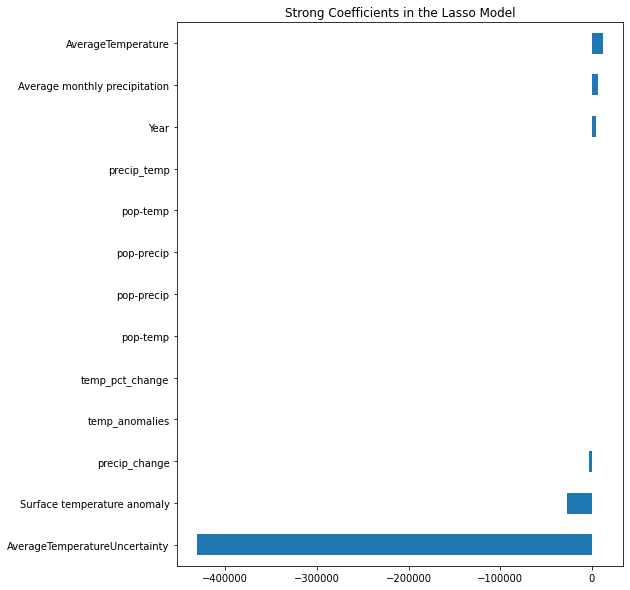

In [31]:
lasso_coefs = lasso_model.coef_

coef_lasso = pd.Series(lasso_model.coef_, index = X_train.columns)


important_coef_lasso = pd.concat([coef_lasso.sort_values().head(20)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
important_coef_lasso.plot(kind = "barh")
plt.title('Strong Coefficients in the Lasso Model')

In [32]:
important_coef_lasso.sort_values()

AverageTemperatureUncertainty   -4.309842e+05
Surface temperature anomaly     -2.680845e+04
precip_change                   -2.956119e+03
temp_anomalies                  -1.223702e+02
temp_pct_change                 -1.968189e+01
pop-temp                        -9.477467e-05
pop-precip                      -0.000000e+00
pop-precip                       3.783729e-19
pop-temp                         8.615452e-04
precip_temp                      2.297993e+02
Year                             4.660047e+03
Average monthly precipitation    6.256210e+03
AverageTemperature               1.187893e+04
dtype: float64

## Building a model, uses climate to predict yields

### Based on Country and Year

In [33]:
df.head()

,Unnamed: 0,Unnamed: 0.1,index,Country,Code_x,Year,cereals,potatoes,beans,sugar,...,yield_percent_change,goal_percent_change,yield_goal_diff,country_cat,temp_anomalies,temp_pct_change,precip_change,precip_temp,pop-temp,pop-precip
0,0,0,0,Afghanistan,AFG,1961,11151.0,86667.0,0.0,250000.0,...,0.000000,0.024,0.000000,0,14.014917,0.000000,0.000000,32.120313,9169000.0,9169000.0
1,1,1,1,Afghanistan,AFG,1962,10790.0,76667.0,0.0,250000.0,...,-0.029789,0.024,0.053789,0,13.438667,-0.041117,-0.178594,25.828087,9351000.0,9351000.0
2,2,2,2,Afghanistan,AFG,1963,9858.0,81333.0,0.0,250000.0,...,0.011065,0.024,0.012935,0,15.863417,0.180431,0.140633,32.166510,9543000.0,9543000.0
3,3,3,3,Afghanistan,AFG,1964,10828.0,86000.0,0.0,250000.0,...,0.016522,0.024,0.007478,0,12.054917,-0.240081,0.062304,29.741723,9745000.0,9745000.0
4,4,4,4,Afghanistan,AFG,1965,10989.0,88000.0,0.0,255000.0,...,0.020647,0.024,0.003353,0,14.141833,0.173117,0.030711,33.037539,9956000.0,9956000.0


In [34]:
df['Year'] = df['Year'].astype('category')

In [35]:
pre_features = df[['Year','Country', 'temp_pct_change', 
                   'Average monthly precipitation', 'precip_change', 
                   'total_yield', 'pop-temp', 'pop-precip','AverageTemperatureUncertainty']]

In [36]:
#One hot encoding Year and Country.
yield_df_onehot = pd.get_dummies(pre_features, columns=['Country', 'Year'], prefix = ['Country', 'Year'])
features=yield_df_onehot.loc[:, yield_df_onehot.columns != 'total_yield']

label = pre_features['total_yield']

features.tail()

,temp_pct_change,Average monthly precipitation,precip_change,pop-temp,pop-precip,AverageTemperatureUncertainty,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,...,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013
7703,0.006590,17.015185,0.050813,1031000.0,1031000.0,0.524000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7704,0.000905,17.916482,0.052970,1076000.0,1076000.0,0.517375,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7705,0.023114,21.398030,0.194321,287000.0,287000.0,0.453917,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7706,0.030034,29.208182,0.364994,295000.0,295000.0,0.402083,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7707,-0.012243,19.776970,-0.322896,303000.0,303000.0,0.488667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#scale features 

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
features=scaler.fit_transform(features)

In [38]:
#Train, test, split. 
train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.3, random_state=42)

In [40]:
#model Comparison

from sklearn.metrics import r2_score
def compare_models(model):
    model_name = model.__class__.__name__
    fit=model.fit(train_data,train_labels)
    y_pred=fit.predict(test_data)
    r2=r2_score(test_labels,y_pred)
    return([model_name,r2])

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

models = [
    GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0),
     RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0),
    svm.SVR(),
   DecisionTreeRegressor()
]

In [42]:
model_train=list(map(compare_models,models))

print(model_train, sep = "\n")

[['GradientBoostingRegressor', 0.795000932215182], ['RandomForestRegressor', 0.3642110554263229], ['SVR', -0.052074668714240824], ['DecisionTreeRegressor', 0.8878491640221042]]


In [44]:
yield_df_onehot.head()

,temp_pct_change,Average monthly precipitation,precip_change,total_yield,pop-temp,pop-precip,AverageTemperatureUncertainty,Country_Afghanistan,Country_Albania,Country_Algeria,...,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013
0,0.000000,2.283719,0.000000,347818,9169000.0,9169000.0,0.398083,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.041117,1.875860,-0.178594,337457,9351000.0,9351000.0,0.406167,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.180431,2.139667,0.140633,341191,9543000.0,9543000.0,0.401250,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.240081,2.272978,0.062304,346828,9745000.0,9745000.0,0.449417,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.173117,2.342783,0.030711,353989,9956000.0,9956000.0,0.408083,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#setting test data to columns from dataframe and excluding 'yield' values where ML model should be predicting 

test_df = pd.DataFrame(test_data,columns=yield_df_onehot.loc[:, yield_df_onehot.columns != 'total_yield'].columns) 


In [46]:
# using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe
cntry=test_df[[col for col in test_df.columns if 'Country' in col]].stack()[test_df[[col for col in test_df.columns if 'Country' in col]].stack()>0]
cntrylist=list(pd.DataFrame(cntry).index.get_level_values(1))
countries=[i.split("_")[1] for i in cntrylist]


In [47]:
#Do same for years 
itm=test_df[[col for col in test_df.columns if 'Year' in col]].stack()[test_df[[col for col in test_df.columns if 'Year' in col]].stack()>0]
itmlist=list(pd.DataFrame(itm).index.get_level_values(1))
items=[i.split("_")[1] for i in itmlist]

In [48]:
#drop year and country cols 
test_df.drop([col for col in test_df.columns if 'Year' in col],axis=1,inplace=True)
test_df.drop([col for col in test_df.columns if 'Country' in col],axis=1,inplace=True)
test_df.head()

,temp_pct_change,Average monthly precipitation,precip_change,pop-temp,pop-precip,AverageTemperatureUncertainty
0,0.994806,0.265382,0.010001,0.005427,0.005427,0.048612
1,0.994839,0.028639,0.013319,0.003079,0.003079,0.117318
2,0.994839,0.140386,0.009414,0.164826,0.164826,0.012021
3,0.994820,0.169948,0.009985,0.000787,0.000787,0.146249
4,0.994823,0.303049,0.013842,0.008531,0.008531,0.158211


In [49]:
#readd Year and country 
test_df['Country']=countries
test_df['Year']=items
test_df.head()

,temp_pct_change,Average monthly precipitation,precip_change,pop-temp,pop-precip,AverageTemperatureUncertainty,Country,Year
0,0.994806,0.265382,0.010001,0.005427,0.005427,0.048612,Switzerland,2008
1,0.994839,0.028639,0.013319,0.003079,0.003079,0.117318,Turkmenistan,1997
2,0.994839,0.140386,0.009414,0.164826,0.164826,0.012021,United States,1980
3,0.994820,0.169948,0.009985,0.000787,0.000787,0.146249,Gambia,1996
4,0.994823,0.303049,0.013842,0.008531,0.008531,0.158211,Madagascar,1991


In [50]:
test_df.sort_values(by = ['Country', 'Year'])

,temp_pct_change,Average monthly precipitation,precip_change,pop-temp,pop-precip,AverageTemperatureUncertainty,Country,Year
1408,0.994820,0.057536,0.010539,0.006538,0.006538,0.191032,Afghanistan,1961
1417,0.994824,0.053494,0.008776,0.007778,0.007778,0.210241,Afghanistan,1969
1412,0.994825,0.055000,0.010454,0.009067,0.009067,0.195687,Afghanistan,1975
1949,0.994825,0.065893,0.012613,0.009250,0.009250,0.214248,Afghanistan,1976
995,0.994810,0.050080,0.010815,0.009536,0.009536,0.234812,Afghanistan,1978
...,...,...,...,...,...,...,...,...
1465,0.994835,0.103560,0.007849,0.008628,0.008628,0.102115,Zimbabwe,2005
329,0.994809,0.135517,0.013801,0.008684,0.008684,0.132284,Zimbabwe,2006
544,0.994818,0.141092,0.010747,0.008845,0.008845,0.215721,Zimbabwe,2008
543,0.994819,0.130695,0.009758,0.008951,0.008951,0.218137,Zimbabwe,2009


In [51]:
clf=DecisionTreeRegressor()
model=clf.fit(train_data,train_labels)

test_df["yield_predicted"]= model.predict(test_data)
test_df["yield_actual"]=pd.DataFrame(test_labels)["total_yield"].tolist()
test_group=test_df.groupby("Country")
test_group.apply(lambda x: r2_score(x.yield_actual,x.yield_predicted))

Country
Afghanistan      -5.718063
Albania          -0.223148
Algeria           0.950379
Angola           -2.324839
Argentina         0.606624
                    ...   
Vietnam           0.812320
Western Sahara   -0.177330
Yemen            -0.129458
Zambia            0.890684
Zimbabwe          0.320515
Length: 158, dtype: float64

In [52]:
test_df

,temp_pct_change,Average monthly precipitation,precip_change,pop-temp,pop-precip,AverageTemperatureUncertainty,Country,Year,yield_predicted,yield_actual
0,0.994806,0.265382,0.010001,0.005427,0.005427,0.048612,Switzerland,2008,554126.0,551114
1,0.994839,0.028639,0.013319,0.003079,0.003079,0.117318,Turkmenistan,1997,49184.0,118998
2,0.994839,0.140386,0.009414,0.164826,0.164826,0.012021,United States,1980,1242499.0,1191875
3,0.994820,0.169948,0.009985,0.000787,0.000787,0.146249,Gambia,1996,135399.0,140014
4,0.994823,0.303049,0.013842,0.008531,0.008531,0.158211,Madagascar,1991,595876.0,579082
...,...,...,...,...,...,...,...,...,...,...
2308,0.994822,0.026131,0.015682,0.002513,0.002513,0.099699,Jordan,1990,208537.0,329002
2309,0.994820,0.028484,0.008818,0.003283,0.003283,0.207766,Niger,1971,118632.0,439701
2310,0.994829,0.267347,0.013434,0.002186,0.002186,0.128395,Albania,1998,114048.0,181108
2311,0.994812,0.361568,0.010830,0.069205,0.069205,0.059042,Japan,1963,946205.0,776567


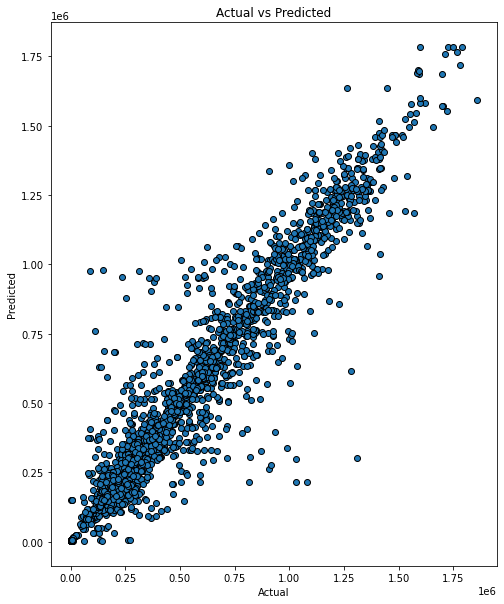

In [54]:
# So let's run the model actual values against the predicted ones 

fig, ax = plt.subplots() 

ax.scatter(test_df["yield_actual"], test_df["yield_predicted"],edgecolors=(0, 0, 0))

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()

In [56]:
imp = model.feature_importances_

varimp= {'imp':model.feature_importances_, 'names':yield_df_onehot.columns[yield_df_onehot.columns!="total_yield"]}

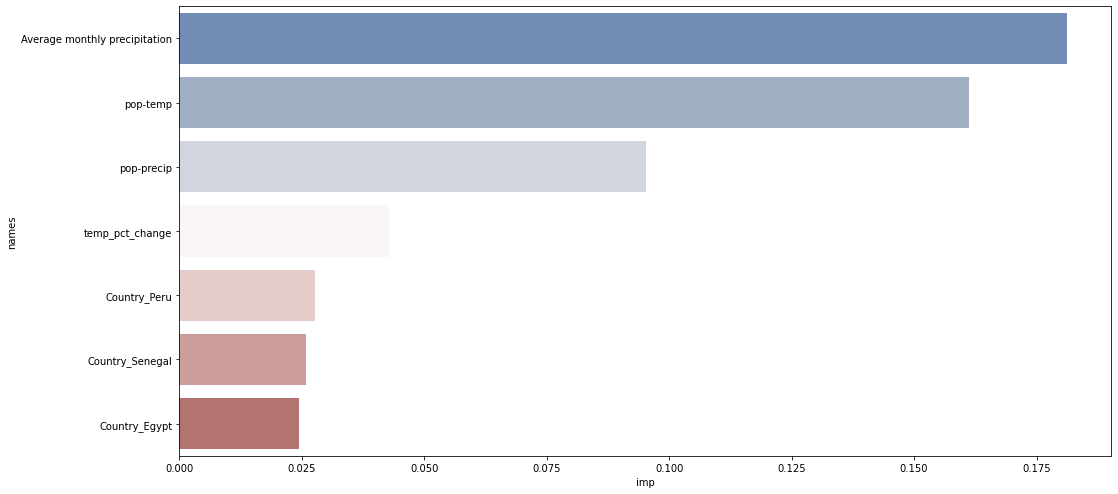

In [57]:
a4_dims = (16.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
factors=pd.DataFrame.from_dict(varimp)
factors.sort_values(ascending=False,by=["imp"],inplace=True)
factors=factors.dropna()
factors=factors.nlargest(7, 'imp')
sns.barplot(x="imp",y="names",palette="vlag",data=factors,orient="h",ax=ax);

In [59]:
corr_matrix = df.corr()
corr_matrix.total_yield.sort_values(ascending = False)

total_yield                      1.000000e+00
sugar                            9.416351e-01
cassava                          4.912067e-01
soybeans                         3.912926e-01
precip_temp                      3.474491e-01
palm-oil                         3.470676e-01
Average monthly precipitation    3.059395e-01
temp_anomalies                   2.973152e-01
AverageTemperature               2.952387e-01
Population                       2.225461e-01
pop-temp                         2.225461e-01
pop-precip                       2.225461e-01
yield_change                     1.366477e-01
potatoes                         1.275295e-01
cereals                          9.604371e-02
beans                            8.560677e-02
country_cat                      6.849313e-02
Unnamed: 0.1                     2.851546e-02
Unnamed: 0                       2.851546e-02
index                            2.791550e-02
temp_pct_change                  7.274937e-03
Surface temperature anomaly      7

## Now use this model to predict mitigation and no mitigaiton yields 

### No mitigation 

In [60]:
no_mitigation_merged.head()

,Year,reference,precip_reference,temp_no_mitigation,precip_no_mitigation,Country,cereals,potatoes,beans,sugar,...,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,log_pop,Precipitation Projected,Temperature Projected,temp_anoms
0,2000,0.52,0.02900,20.089,9.16500,Afghanistan,8063.0,167857.0,0.0,190000.0,...,0.024,0.036932,16.917833,NaN,NaN,24.650437,16.849502,1.715942,15.828667,0.000000
190,2001,0.75,0.17944,20.319,9.31544,Afghanistan,10067.0,167857.0,0.0,190000.0,...,0.024,0.018523,17.448083,0.006186,-0.002376,23.864507,16.888528,1.711865,15.926587,0.587525
349,2002,0.91,0.32988,20.479,9.46588,Afghanistan,16698.0,164286.0,0.0,190000.0,...,0.024,0.015683,17.317667,0.006148,-0.002382,33.213400,16.933505,1.707787,16.024508,1.175050
507,2003,0.96,0.48032,20.529,9.61632,Afghanistan,14580.0,166667.0,0.0,181818.0,...,0.024,0.045346,15.996000,0.006111,-0.002388,33.942645,16.980184,1.703710,16.122429,1.762574
665,2004,0.93,0.63076,20.499,9.76676,Afghanistan,13348.0,176471.0,0.0,200000.0,...,0.024,-0.049689,17.530917,0.006074,-0.002393,29.385955,17.023406,1.699632,16.220350,2.350099


In [61]:
no_mitigation_merged[300:350]

,Year,reference,precip_reference,temp_no_mitigation,precip_no_mitigation,Country,cereals,potatoes,beans,sugar,...,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,log_pop,Precipitation Projected,Temperature Projected,temp_anoms
15303,2095,9.45,22.48000,29.019,31.61600,Algeria,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002837,-0.003069,NaN,11.165586,0.600502,34.616063,56.402376
15462,2096,9.55,22.82400,29.119,31.96000,Algeria,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002829,-0.003079,NaN,11.166104,0.598654,34.713983,56.989901
15621,2097,9.59,23.16800,29.159,32.30400,Algeria,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002821,-0.003088,NaN,11.166445,0.596805,34.811904,57.577426
15780,2098,9.65,23.51200,29.219,32.64800,Algeria,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002813,-0.003098,NaN,11.166597,0.594956,34.909825,58.164950
15939,2099,9.92,23.85600,29.489,32.99200,Algeria,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002805,-0.003107,NaN,11.166547,0.593108,35.007746,58.752475
16098,2100,9.89,24.20000,29.459,33.33600,Algeria,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.002797,-0.003117,NaN,11.166280,0.591259,35.105667,59.340000
3,2000,0.52,0.02900,20.089,9.16500,Angola,5644.0,29885.0,3855.0,372340.0,...,0.024,0.029105,23.160667,-0.353908,14.059342,197.080341,16.612487,8.903970,22.681500,0.000000
193,2001,0.75,0.17944,20.319,9.31544,Angola,5854.0,42552.0,4004.0,378947.0,...,0.024,-0.025904,23.532917,0.004317,-0.002376,173.044093,16.645542,8.882812,22.779421,0.587525
352,2002,0.91,0.32988,20.479,9.46588,Angola,6272.0,42754.0,3793.0,378947.0,...,0.024,-0.001805,24.025500,0.004299,-0.002382,180.064923,16.678797,8.861654,22.877342,1.175050
510,2003,0.96,0.48032,20.529,9.61632,Angola,6461.0,45212.0,4010.0,378947.0,...,0.024,0.040726,24.336583,0.004280,-0.002388,163.648260,16.712582,8.840497,22.975262,1.762574


### Need to limit to 52 years of data so I can make predictions using the model created above 
 Need same amount of features 

In [63]:
no_mitigation_merged.head()

,Year,reference,precip_reference,temp_no_mitigation,precip_no_mitigation,Country,cereals,potatoes,beans,sugar,...,goal_percent_change,yield_goal_diff,temp_anomalies,temp_pct_change,precip_change,precip_temp,log_pop,Precipitation Projected,Temperature Projected,temp_anoms
0,2000,0.52,0.02900,20.089,9.16500,Afghanistan,8063.0,167857.0,0.0,190000.0,...,0.024,0.036932,16.917833,NaN,NaN,24.650437,16.849502,1.715942,15.828667,0.000000
190,2001,0.75,0.17944,20.319,9.31544,Afghanistan,10067.0,167857.0,0.0,190000.0,...,0.024,0.018523,17.448083,0.006186,-0.002376,23.864507,16.888528,1.711865,15.926587,0.587525
349,2002,0.91,0.32988,20.479,9.46588,Afghanistan,16698.0,164286.0,0.0,190000.0,...,0.024,0.015683,17.317667,0.006148,-0.002382,33.213400,16.933505,1.707787,16.024508,1.175050
507,2003,0.96,0.48032,20.529,9.61632,Afghanistan,14580.0,166667.0,0.0,181818.0,...,0.024,0.045346,15.996000,0.006111,-0.002388,33.942645,16.980184,1.703710,16.122429,1.762574
665,2004,0.93,0.63076,20.499,9.76676,Afghanistan,13348.0,176471.0,0.0,200000.0,...,0.024,-0.049689,17.530917,0.006074,-0.002393,29.385955,17.023406,1.699632,16.220350,2.350099


In [64]:
no_mitigation_merged['pop-temp'] = (no_mitigation_merged['Population'] / no_mitigation_merged['Temperature Projected']) *no_mitigation_merged['Temperature Projected'] 
no_mitigation_merged['pop-precip'] = (no_mitigation_merged['Population'] / no_mitigation_merged['Precipitation Projected']) * no_mitigation_merged['Precipitation Projected']


In [65]:
df_58 = no_mitigation_merged[np.isin(no_mitigation_merged,[2000, 2002, 2004,2006,2008,2010,2012,
2014, 2016,2018,2020,2022,2024,2026,2028,2030,2032,2034,2036,2038,2040,2042,2044,2046,
2048,2050,2052,2054,2056,2058,2060,2062,2064,2066,2068,2070,2072,2074,2076,2078,2080,2082,2084,2086,
2088,2090,2092,2094,2096,2098,2100]).any(axis=1)]

In [66]:
no_mitigation_merged['Country'].fillna('Unknown', inplace = True)


no_mitigation_merged['Year'] = no_mitigation_merged['Year'].astype('int')


df_58  = no_mitigation_merged[np.isin(no_mitigation_merged,[2000, 2002, 2004,2006,2008,2010,2012,
2014, 2016,2018,2020,2022,2024,2026,2028,2030,2032,2034,2036,2038,2040,2042,2044,2046,
2048,2050,2052,2054,2056,2058,2060,2062,2064,2066,2068,2070,2072,2074,2076,2078,2080,2082,2084,2086,
2088,2090,2092,2094,2096,2098,2099,2100]).any(axis=1)]

df_58['Year'] = df_58['Year'].astype('category')

               
#Pre processing data: 
no_mitigation_use = df_58[['Year','Country', 'temp_pct_change', 
                   'Precipitation Projected', 'precip_change', 
                   'total_yield', 'pop-temp', 'pop-precip', 'temp_anoms']]

#no_mitigation_use.fillna(0, inplace = True)

no_mit_df_onehot = pd.get_dummies(no_mitigation_use, columns=['Year','Country'], prefix = ['Year','Country'])


features_no_mit =no_mit_df_onehot.loc[:,no_mit_df_onehot.columns != 'total_yield']

features_no_mit.fillna(0,inplace = True)

features_no_mit.head()

label = no_mitigation_use['total_yield']

#scale data
scaler=MinMaxScaler()
features_no_mit = scaler.fit_transform(features_no_mit)


no_mit_test_df = pd.DataFrame(features_no_mit,columns=no_mit_df_onehot.loc[:, no_mit_df_onehot.columns != 'total_yield'].columns) 


# using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe
cntry = no_mit_test_df[[col for col in no_mit_test_df.columns if 'Country' in col]].stack()[no_mit_test_df[[col for col in no_mit_test_df.columns if 'Country' in col]].stack()>0]

cntrylist= list(pd.DataFrame(cntry).index.get_level_values(1))

countries= [i.split("_")[1] for i in cntrylist]

itm = no_mit_test_df[[col for col in no_mit_test_df.columns if 'Year' in col]].stack()[no_mit_test_df[[col for col in no_mit_test_df.columns if 'Year' in col]].stack()>0]
itmlist=list(pd.DataFrame(itm).index.get_level_values(1))
items=[i.split("_")[1] for i in itmlist]

no_mit_test_df.drop([col for col in no_mit_test_df.columns if 'Country' in col],axis=1,inplace=True)
no_mit_test_df.head()

no_mit_test_df.drop([col for col in no_mit_test_df.columns if 'Year' in col],axis=1,inplace=True)

no_mit_test_df.fillna(0, inplace = True)

no_mit_test_df

no_mit_test_df['Country'] = countries
no_mit_test_df.head()

no_mit_test_df['Year']=items

no_mit_test_df.head()

no_mit_test_df["yield_predicted"]= model.predict(features_no_mit)

no_mit_test_group=no_mit_test_df.groupby("Country")


no_mit_test_df

,temp_pct_change,Precipitation Projected,precip_change,pop-temp,pop-precip,temp_anoms,Country,Year,yield_predicted
0,0.685034,0.054868,0.003910,0.015012,0.015012,0.000000,Afghanistan,2000,204999.0
1,0.685736,0.054733,0.003900,0.015610,0.015610,0.009901,Afghanistan,2001,204999.0
2,0.685732,0.054598,0.003900,0.016328,0.016328,0.019802,Afghanistan,2002,204999.0
3,0.685723,0.054328,0.003900,0.017864,0.017864,0.039604,Afghanistan,2004,204999.0
4,0.685715,0.054057,0.003900,0.019096,0.019096,0.059406,Afghanistan,2006,702668.0
...,...,...,...,...,...,...,...,...,...
8313,0.685390,0.128979,0.003898,0.000022,0.000022,0.940594,Zimbabwe,2094,142857.0
8314,0.685388,0.128175,0.003897,0.000022,0.000022,0.960396,Zimbabwe,2096,142857.0
8315,0.685386,0.127371,0.003897,0.000022,0.000022,0.980198,Zimbabwe,2098,142857.0
8316,0.685385,0.126969,0.003897,0.000022,0.000022,0.990099,Zimbabwe,2099,142857.0


In [67]:
no_mit_test_df[no_mit_test_df['Country']== 'Nigeria']

,temp_pct_change,Precipitation Projected,precip_change,pop-temp,pop-precip,temp_anoms,Country,Year,yield_predicted
5457,0.652633,0.300361,0.025161,0.088342,0.088342,0.000000,Nigeria,2000,497942.0
5458,0.685429,0.298923,0.003900,0.092902,0.092902,0.019802,Nigeria,2002,524603.0
5459,0.685427,0.297486,0.003900,0.097760,0.097760,0.039604,Nigeria,2004,524603.0
5460,0.685424,0.296049,0.003900,0.102974,0.102974,0.059406,Nigeria,2006,543132.0
5461,0.685421,0.294612,0.003900,0.108560,0.108560,0.079208,Nigeria,2008,543132.0
5462,0.685419,0.293175,0.003900,0.114508,0.114508,0.099010,Nigeria,2010,543132.0
5463,0.685416,0.291738,0.003900,0.120812,0.120812,0.118812,Nigeria,2012,543132.0
5464,0.685412,0.289582,0.003900,0.000127,0.000127,0.148515,Nigeria,2014,182584.0
5465,0.685410,0.288145,0.003900,0.000134,0.000134,0.168317,Nigeria,2016,366941.0
5466,0.685407,0.286708,0.003900,0.000141,0.000141,0.188119,Nigeria,2018,182584.0


In [68]:
no_mitigation_preds = model.predict(features_no_mit)

In [69]:
no_mitigation_preds

array([204999., 204999., 204999., ..., 142857., 142857., 142857.])

#### These predictions were exported and then used to predict and model hunger 